<a href="https://colab.research.google.com/github/Abonvicine/ESTUDOS---Gerais/blob/main/TG_Previs%C3%A3o_de_carga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from datetime import date

import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
hoje = date.today()
diaSemana = hoje.weekday()
hoje = str(hoje)

In [ ]:
baseDIR = "/content/drive/MyDrive/TG/DADOS SUDESTE"
os.listdir(baseDIR)

['SECO_2021-01-27_CARGAHIST.csv',
 'SECO_2021-01-27_TEMPHIST.csv',
 'SECO_2021-01-27_FERIADOS.csv',
 'SECO_2021-01-27_SEPARADOR.csv',
 'SECO_2021-01-27_HORAVERAO.csv',
 'SECO_2021-01-27_PATAMARES.csv',
 'SECO_2021-01-27_HORIZONTE.csv',
 'SECO_2021-01-27_TEMPPREV.csv',
 'SECO_2021-01-27_COMBINA.csv']

In [ ]:
historicoCarga = pd.read_csv(os.path.join(baseDIR,'SECO_2021-01-27_CARGAHIST.csv'),sep=";",decimal=",")
historicoTemperatura = pd.read_csv(os.path.join(baseDIR,'SECO_2021-01-27_TEMPHIST.csv'),sep=";",decimal=",")

In [ ]:
def basePreprocessing(carga,temperatura):
    dataset = carga.merge(temperatura)
    dataset = dataset.drop(["Min"], axis = 1 )
    dataset = dataset.rename({'Ano': 'Year', 'Mes': 'Month',"Dia":"Day"}, axis=1)
    dataset["Date"] = pd.to_datetime(dataset[["Year","Month","Day"]])
    dataset["Weekday"] = dataset["Date"].dt.dayofweek

    dataset["Carga_Var"] = dataset["Carga"].pct_change()
    dataset["Temp_Var"] = dataset["Temperatura"].pct_change()

    dataset["Carga D-1"] = dataset["Carga"].shift(1, axis = 0)
    dataset = dataset.iloc[1:]

    correlation = dataset["Carga"].corr(dataset["Temperatura"])

    return dataset, correlation

def baseNormalizer(dataset, normalizer, normalize_fit = True):
    
    normalizadorCarga = normalizer
    normalizadorTemp = normalizer

    if normalize_fit:
        dataset[["Carga"]] = normalizadorCarga.fit_transform(dataset[["Carga"]])
        dataset[["Carga D-1"]] = normalizadorCarga.transform(dataset[["Carga D-1"]])
        dataset[["Temperatura"]] = normalizadorTemp.fit_transform(dataset[["Temperatura"]])

    dummies = pd.get_dummies(dataset["Weekday"],prefix="Dia")
    dataset = dataset.join(dummies)
    dataset = dataset.drop(["Date","Weekday"], axis = 1 )
    dataset = dataset.dropna()

    return dataset , normalizadorCarga, normalizadorTemp

In [ ]:
historico, correlation = basePreprocessing(historicoCarga,historicoTemperatura)
historico, normalizadorCarga, normalizadorTemp = baseNormalizer(historico,StandardScaler())
historico = historico.dropna()

cols = [  
    'Year',
    'Month',
    'Day',
    'Hora',
    'Carga',
    'Carga D-1',
    'Temperatura',
    'Carga_Var',
    'Temp_Var',
    'Dia_0',
    'Dia_1',
    'Dia_2',
    'Dia_3',
    'Dia_4',
    'Dia_5',
    'Dia_6']

historico = historico[cols]
base = historico.values
historico.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,61983.0,2017.041318,2.029704,2014.000000,2015.000000,2017.000000,2019.000000,2021.000000
Month,61983.0,6.466660,3.475342,1.000000,3.000000,6.000000,9.000000,12.000000
Day,61983.0,15.708952,8.791479,1.000000,8.000000,16.000000,23.000000,31.000000
Hora,61983.0,11.501605,6.921458,0.000000,6.000000,12.000000,18.000000,23.000000
Carga,61983.0,0.000020,1.000053,-2.634665,-0.782271,0.065949,0.754835,2.874397
Carga D-1,61983.0,-0.000054,1.000034,-2.634665,-0.782324,0.065879,0.754765,2.874397
Temperatura,61983.0,-0.000010,1.000023,-4.796906,-0.645334,-0.026327,0.695301,3.132659
Carga_Var,61983.0,0.000984,0.044287,-0.132422,-0.029432,-0.000734,0.029325,0.215393
Temp_Var,61983.0,0.001163,0.052415,-0.764231,-0.026528,-0.009299,0.021339,2.655952
Dia_0,61983.0,0.142878,0.349951,0.000000,0.000000,0.000000,0.000000,1.000000


Text(0, 0.5, 'Temperatura [°C]')

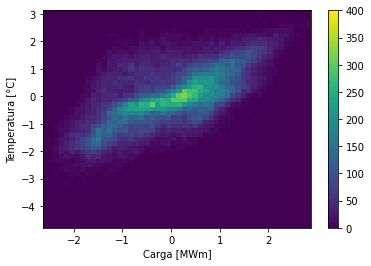

In [ ]:
plt.hist2d(historico['Carga'], historico['Temperatura'], bins=(50, 50), vmax=400)

plt.colorbar()
plt.xlabel('Carga [MWm]')
plt.ylabel('Temperatura [°C]')

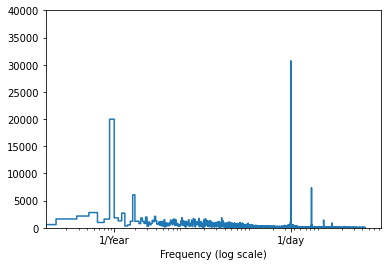

In [ ]:
fft = tf.signal.rfft(historico['Temperatura'])
f_per_dataset = np.arange(0, len(fft))
n_samples_h = len(historico['Temperatura'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))

plt.xscale('log')
plt.ylim(0, 40000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [ ]:
print(f"A correlação é {round(correlation,4)}")

A correlação é 0.6494


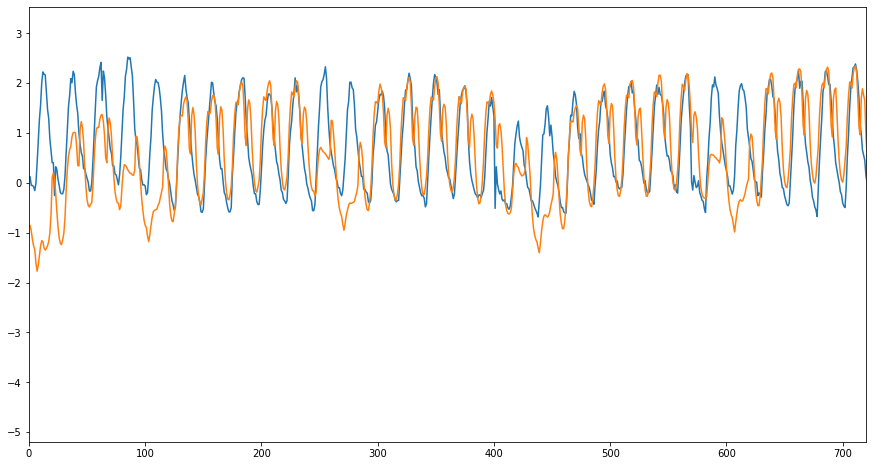

In [ ]:
plt.figure(figsize=(15, 8))
axes = plt.gca()
axes.set_xlim(0,720)

plt.plot(historico["Temperatura"])
plt.plot(historico["Carga"])

In [ ]:
Xdataset = historico[['Carga','Temperatura','Dia_1','Dia_2','Dia_3','Dia_4','Dia_5','Dia_6']]

column_indices = {name: i for i, name in enumerate(Xdataset.columns)}

n = len(historico)

dias= 30

print(f'Tamanho original da base X = {base_X.shape}, Y = {base_Y.shape}')

x_train = Xdataset[0:int(n*0.7)]

x_valid = Xdataset[int(n*0.7):int(n*0.9)]

x_test = Xdataset[int(n*0.9):]

num_features = historico.shape[1]

print(f'    formato dados de treino X = {x_train.shape}, Y = {y_train.shape}')
print(f'    formato dados de validação X = {x_valid.shape}, Y = {y_valid.shape}')
print(f'    formato dados de teste X = {x_test.shape}, Y = {y_test.shape}')

Tamanho original da base X = (61983, 8), Y = (61983, 1)
    formato dados de treino X = (43388, 8), Y = (43388, 1)
    formato dados de validação X = (12396, 8), Y = (12396, 1)
    formato dados de teste X = (6199, 8), Y = (6199, 1)


In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df = x_train, val_df=x_valid , test_df=x_test,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w2 = WindowGenerator(input_width=720, label_width=24, shift=24,
                     label_columns=['Carga'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(x_train[:w2.total_window_size]),
                           np.array(x_train[100:100+w2.total_window_size]),
                           np.array(x_train[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 744, 8)
Inputs shape: (3, 720, 8)
labels shape: (3, 24, 1)


In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='Carga', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Carga')

WindowGenerator.plot = plot

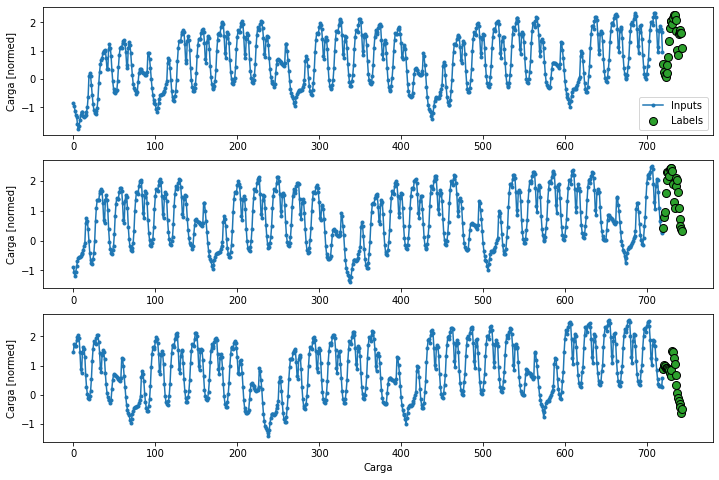

In [ ]:
w2.plot()

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 720, 8), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 720, 8)
Labels shape (batch, time, features): (32, 24, 1)


In [ ]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience = 2):
  
    es = EarlyStopping(monitor = "loss", min_delta = 1e-10, patience = 10, verbose = 1)
    rlr = ReduceLROnPlateau(monitor = "loss", factor = 0.2, patience = 5, verbose = 1)
    mcp = ModelCheckpoint(filepath=f"pesos-{date.today()}.h5", monitor = "loss", save_best_only = True, verbose=1)
  
    model.compile(optimizer = tf.optimizers.Adam(), loss = tf.losses.MeanSquaredError(), metrics = [tf.metrics.MeanAbsoluteError()])
  
    history = model.fit(window.train, epochs = MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[es,rlr,mcp])
    return history

In [ ]:
history = compile_and_fit(linear, wide_window)

val_performance['Linear'] = linear.evaluate(wide_window.val)
performance['Linear'] = linear.evaluate(wide_window.test, verbose=0)

In [ ]:
wide_window.plot(linear)

In [ ]:
plt.bar(x = range(len(x_train.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(x_train.columns)))
_ = axis.set_xticklabels(x_train.columns, rotation=90)

In [ ]:
def createModel():
    model = Sequential()

    model.add(LSTM(units = 100, return_sequences = True))
    model.add(Dropout(0.5))

    model.add(LSTM(units = 30))
    model.add(Dropout(0.5))

    model.add(Dense(units = 1)

    return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = createModel()
model.summary()

In [ ]:
lstm_model = createModel()

In [ ]:
print('Input shape:', w2.example[0].shape)
print('Output shape:', model(w2.example[0]).shape)

Input shape: (32, 720, 8)
Output shape: (32, 1)


In [ ]:
history = compile_and_fit(lstm_model, w2)

# Teste e Validação


In [ ]:
model = keras.models.load_model('/content/pesos-2021-02-10.h5') # carrega modelo pré-treinado (OPCIONAL)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 720, 100)          44000     
_________________________________________________________________
dropout (Dropout)            (None, 720, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                15720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 59,751
Trainable params: 59,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
testeDIR = "/content/drive/MyDrive/TG/TESTE" 

In [ ]:
historicoCargaTeste = pd.read_csv(os.path.join(testeDIR,'SECO_2021-02-28_CARGAHIST.csv'),sep=";",decimal=",")
historicoTemperaturaTeste = pd.read_csv(os.path.join(testeDIR,'SECO_2021-02-28_TEMPHIST.csv'),sep=";",decimal=",")

In [ ]:
historicoTeste = basePreprocessing(historicoCargaTeste, historicoTemperaturaTeste)

historicoTeste, _ , _ = baseNormalizer(historicoTeste,
                                        StandardScaler(),
                                        normalize_fit=True)

valorRealTeste = historicoTeste.iloc[:, 4].values
valorRealTeste

In [ ]:
historicoTeste[["Carga"]] = normalizadorCarga.fit_transform(historicoTeste[["Carga"]])
historicoTeste[["Temperatura"]] = normalizadorTemp.fit_transform(historicoTeste[["Temperatura"]])
historicoTeste

In [ ]:
entradas = historicoTeste.values
entradas.shape

(62753, 13)

In [ ]:
X_teste = []
Y_teste = []
for i in range(len(entradas) - diasAnteriores,len(entradas)):
    cargaTeste = entradas[(i - diasAnteriores):i,4]
    cargaVerificada = entradas[i,4]
    tempTeste = entradas[(i+1 - diasAnteriores):i+1,5]
    vetorDiaSemana = entradas[(i+1 - diasAnteriores):i+1,6:]
    
    batchTeste = np.column_stack((cargaTeste,tempTeste,vetorDiaSemana))

    X_teste.append(batchTeste)
    Y_teste.append(cargaVerificada)
    
X_teste = np.array(X_teste)
Y_teste = np.array(Y_teste)
print(X_teste.shape)
print(Y_teste.shape)

In [ ]:
previsoes = model.predict(X_teste)

In [ ]:
previsoes = normalizadorCarga.inverse_transform(previsoes)
previsores

In [ ]:
loss = tf.keras.losses.mean_absolute_percentage_error(Y_teste, previsoes[:,0]).numpy()
loss

156.34515

In [ ]:
previsoes

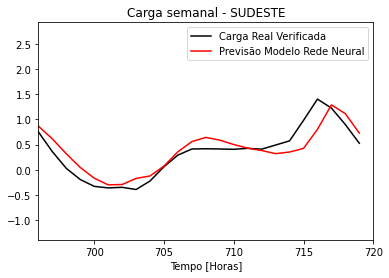

In [ ]:
axes = plt.gca()
axes.set_xlim(696,720)
plt.plot(Y_teste[:], color = "black", label = "Carga Real Verificada")
plt.plot(previsoes[:], color = "red", label = "Previsão Modelo Rede Neural")
plt.title("Carga semanal - SUDESTE")
plt.xlabel("Tempo [Horas]")
plt.ylabel("")
plt.legend()
plt.show()